# IMPORT PACKAGES

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
import time

    #Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None 
    
# Declarings of two Line objects for each line
leftLine = Line()
rightLine = Line()

# TEST IMAGES

In [3]:
os.listdir("video_images/")

['frame1044.jpg',
 'frame12.jpg',
 'frame9.jpg',
 'frame1049.jpg',
 '.ipynb_checkpoints',
 'frame1046.jpg',
 'frame2.jpg',
 'frame1.jpg',
 'frame11.jpg',
 'frame1050.jpg',
 'frame3.jpg',
 'frame13.jpg',
 'frame1043.jpg',
 'frame1048.jpg',
 'frame1041.jpg',
 'frame1045.jpg',
 'frame10.jpg',
 'frame4.jpg',
 'warped.jpg',
 'frame14.jpg',
 'frame6.jpg',
 'frame1042.jpg',
 'frame1047.jpg',
 'frame7.jpg',
 'frame5.jpg',
 'frame8.jpg']

# SHOW IMAGES

In [4]:
# function to show all the images that are contained in the test_images folder
def show_images(images, cmap=None):
    cols = 3
    rows = (len(images)+2)//cols 
    
    plt.figure(figsize=(40, 30))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()
    
test_images = [plt.imread(path) for path in glob.glob('video_images/*.jpg')]
#show_images(test_images)

# HELPER FUNCTIONS

# Camera calibration and distorsion corection

In [5]:
import pickle

# the camera calibration function which makes the calibration for the camera using the chessboard images
def cameraCalibration(nx = 9, ny = 6, img_size = (720, 1280)):
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx * ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        copy = img
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            
            plt.imshow(img)
            plt.title("Chessboard 9x6")

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    # Save the camera calibration result for later use 
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
    
    print("Camera Calibration was successful")

def undistortImage(image):
    
    # Load data from pickle file
    dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    
    # Test undistortion on an image
    img_size = (image.shape[1], image.shape[0])

    # Do the undistorsion of the image using the mtx and dist matrixes
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    
    return dst

Camera Calibration was successful


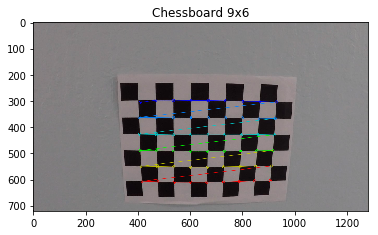

In [6]:
# Run the camera calibration module
cameraCalibration()

# Gradient and color filtering

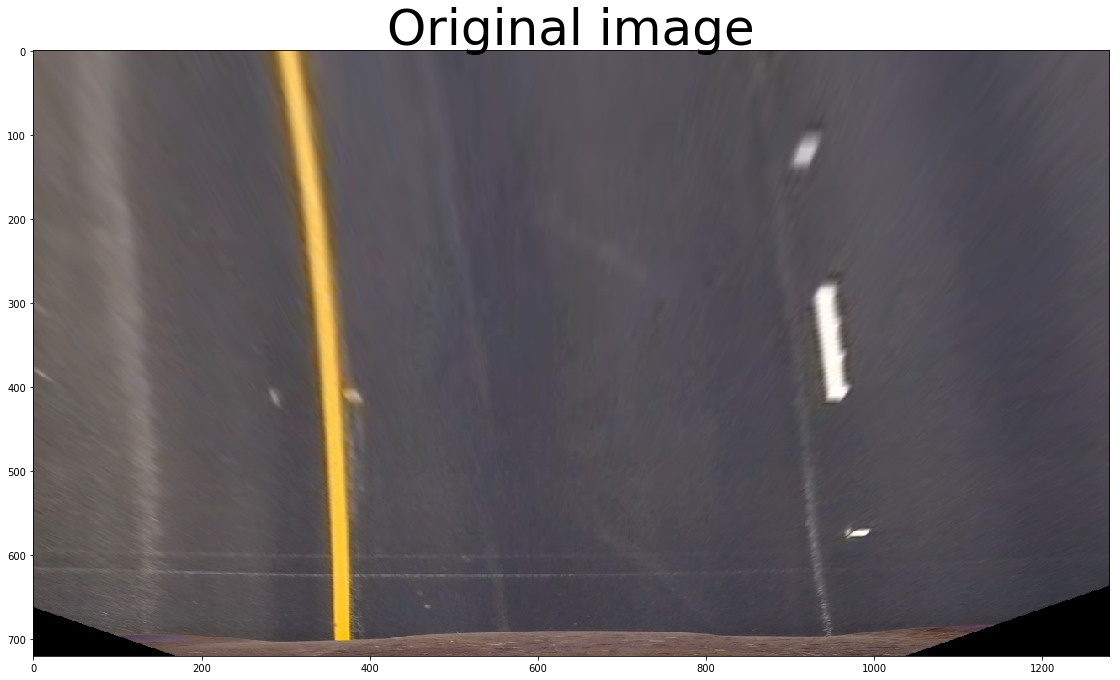

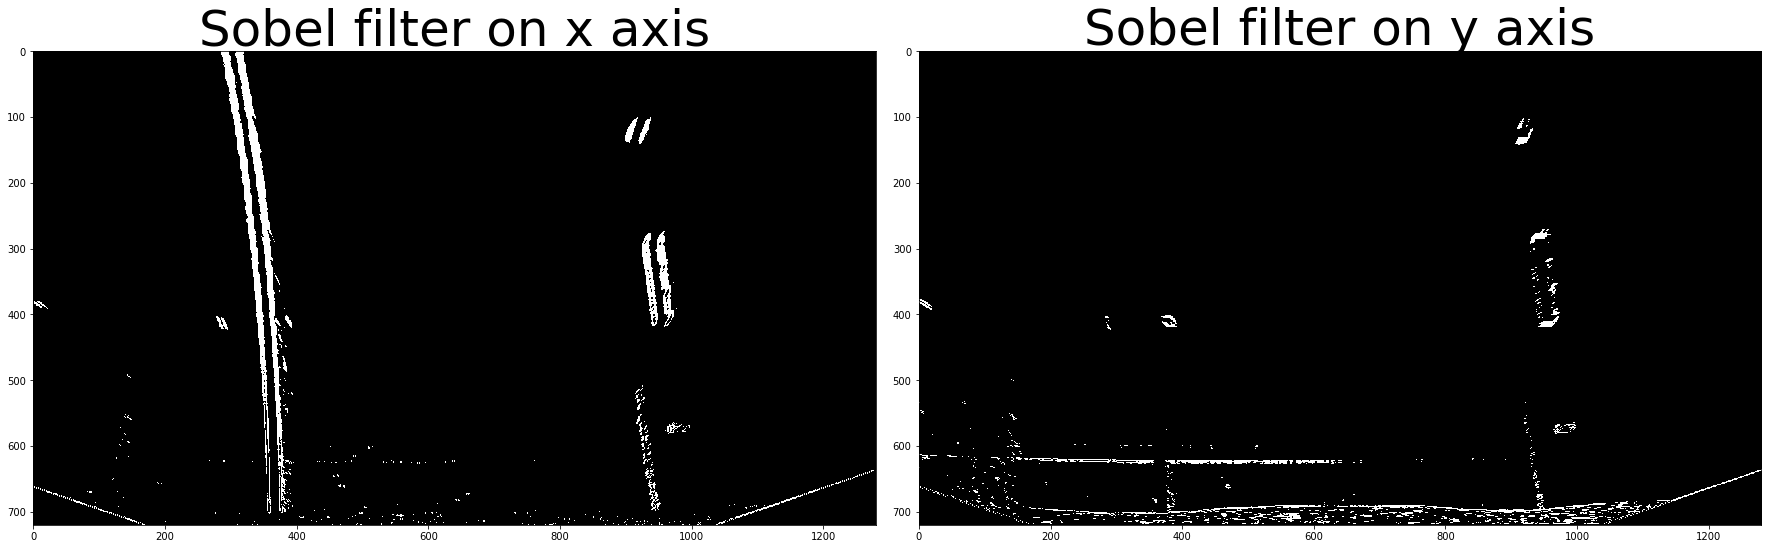

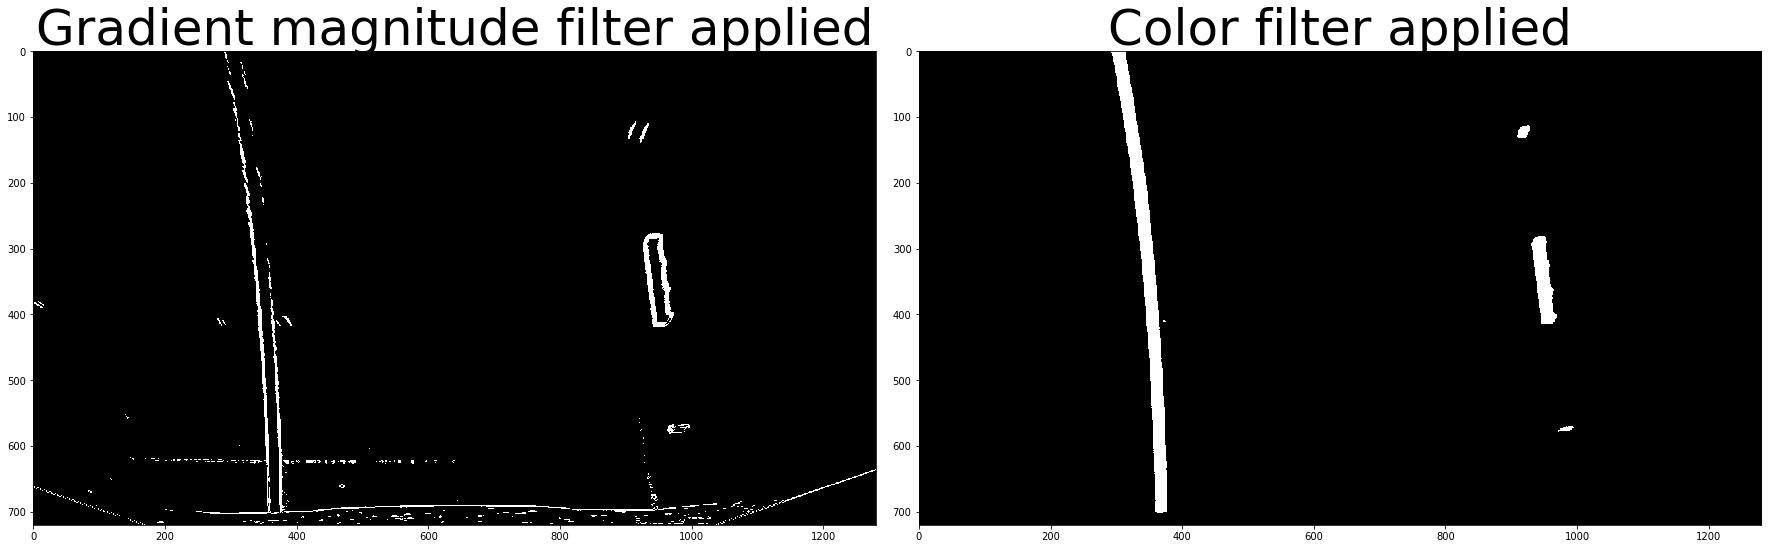

In [39]:
# Two modules for gradient thresholding, including sobel thresholding and gradient magnitude thresholding
def abs_sobel_threshold(image, orient='x', sobel_kernel=3, thresh=(0, 255)):

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

    # 3) Take the absolute value of the derivative or gradient	
    abs_sobel = np.absolute(sobel)

    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))

    # 5) Create a mask of 1's where the scaled gradient magnitude 
        # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # 6) Return this mask as your binary_output 
    return grad_binary

def mag_threshold(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)	

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

    # 3) Calculate the magnitude 
    abs_sobelx = np.sqrt(pow(sobelx, 2))
    abs_sobely = np.sqrt(pow(sobely, 2))
    abs_sobelxy = np.sqrt(pow(sobelx, 2) + pow(sobely, 2))

    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobelxy / np.max(abs_sobelxy))

    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    return mag_binary



# function to threshold the S and L channels of HLS color space and R of 
def color_select(image, threshS=(0, 255), threshL=(0,255), threshR=(0,255)):
    
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    # 2) Apply a threshold to the S channel
#     plt.figure()
#     plt.title('H')
#     plt.imshow(hls[:,:,0], cmap = 'gray')
    
#     plt.figure()
#     plt.title('L')
#     plt.imshow(hls[:,:,1], cmap = 'gray')
    
#     plt.figure()
#     plt.title('S')
#     plt.imshow(hls[:,:,2], cmap = 'gray')
    
    L = hls[:,:,1]
    S = hls[:,:,2]
    R = image[:,:,1]
    binary_output = np.zeros_like(S)
    binary_output[(((S > threshS[0]) & (S <= threshS[1])) & ((R > threshR[0]) & (R <= threshR[1]))) | ((L > threshL[0]) & (L <= threshL[1]))] = 1
    
    # 3) Return a binary image of threshold result
    return binary_output



# function to apply all the thresholds that were implemented above
def applyThresholds(image):
    
    ksize = 3
    gradx = abs_sobel_threshold(image, orient='x', sobel_kernel=7, thresh=(20, 100))
    grady = abs_sobel_threshold(image, orient='y', sobel_kernel=7, thresh=(20, 100))
    mag_binary = mag_threshold(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    
    color_binary = color_select(image, threshS=(100, 255), threshL=(180,255), threshR=(150,255))
    
    f, (ax1) = plt.subplots(1, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image, cmap = None)
    ax1.set_title('Original image', fontsize=50)

    
    plt.figure()
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(gradx, cmap = 'gray')
    ax1.set_title('Sobel filter on x axis', fontsize=50)
    ax2.imshow(grady, cmap='gray')
    ax2.set_title('Sobel filter on y axis', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    plt.figure()
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(mag_binary, cmap = 'gray')
    ax1.set_title('Gradient magnitude filter applied', fontsize=50)
    ax2.imshow(color_binary, cmap='gray')
    ax2.set_title('Color filter applied', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    
    combined = np.zeros_like(color_binary)
    combined[(gradx == 1) | (mag_binary == 1) | (color_binary == 1)] = 1
    
#     show(gradx, 'sobelx', 'gray')
#     show(mag_binary, 'magnitude', 'gray')
#     show(color_binary, 'color', 'gray')
#     show(combined, 'combined', 'gray')
    
    return combined

img = mpimg.imread('video_images/warped.jpg')
combined = applyThresholds(img)
# plt.figure()
# plt.imshow(combined)

In [8]:
# the function which takes the image and makes the perspective transform to the 'bird eye view' perspective
def perspectiveTransform(image):
    
    img_size = (image.shape[1], image.shape[0])
    
    # Vertices extracted manually for performing a perspective transform
    bottom_left = [220,720]
    bottom_right = [1110, 720]
    top_left = [570, 470]
    top_right = [722, 470]

    source = np.float32([bottom_left,bottom_right,top_right,top_left])

    # Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
    bottom_left = [320,720]
    bottom_right = [920, 720]
    top_left = [320, 1]
    top_right = [920, 1]

    dst = np.float32([bottom_left,bottom_right,top_right,top_left])

    # Extracting the M matrix which is the transform matrix of the Perspetive Transformation
    M = cv2.getPerspectiveTransform(source, dst)
    warped = cv2.warpPerspective(image, M, img_size , flags=cv2.INTER_LINEAR)
    
    # Extracting the Minv which is the inverse matrix with which we'll perform the return to the initial perspectiv
    Minv = cv2.getPerspectiveTransform(dst, source)

    return warped, Minv


In [9]:
# Find the polynomial that fits our left and right lanes
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #print(histogram.shape)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    #print(binary_warped.shape)
    #plt.imshow(out_img)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix =  50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    i = 0
    
    # Step through the windows one by one
    for window in range(nwindows):
        
        #print(i)
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # print(str(win_y_low) + " " + str(win_y_high))
        
        i = i + 1
        
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        #print(str(win_xleft_low) + " " + str(win_xleft_high) + " " + str(win_xright_low) + " " + str(win_xright_high))
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    # Working with the output from the last frame and performing 
    # the checkings to see if the lane selections were extracted correctly
    if leftLine.detected == False:
        leftLine.bestx = np.average(left_fitx)
        leftLine.allx = left_fitx
        leftLine.current_fit = left_fit
        leftLine.detected = True
    else:
        if abs(np.average(left_fitx) - leftLine.bestx) > 100:
            left_fit = leftLine.current_fit
            left_fitx = leftLine.allx
            print('Left refit')
        else:
            leftLine.current_fit = left_fit
            leftLine.allx = left_fitx 
            
    if rightLine.detected == False:
        rightLine.bestx = np.average(right_fitx)
        rightLine.allx = right_fitx
        rightLine.current_fit = right_fit
        rightLine.detected = True
    else:
        if abs(np.average(right_fitx) - rightLine.bestx) > 100:
            right_fit = rightLine.current_fit
            right_fitx = rightLine.allx
            print('Right refit')
        else:
            rightLine.current_fit = right_fit 
            rightLine.allx = right_fitx 
    
    out1_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    # Plots the left and right polynomials on the lane lines
    window_img = np.zeros_like(out_img)
    
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+(right_fitx-left_fitx), 
                              ploty])))])   
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 127, 127))
    
    #result = cv2.addWeighted(out1_img, 1, window_img, 0.3, 0)
    result = window_img
    
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return result, left_fit, right_fit




In [10]:
# Calculates the curvature of polynomial functions in meters.
def measure_curvature_real(image, y_eval, left_fit_cr, right_fit_cr):

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Calculation of the relative position to the center
    left_pos = abs(0 - (left_fit_cr[0] * (y_eval) ** 2 + left_fit_cr[1] *(y_eval) + left_fit_cr[2]))
    right_pos = abs(image.shape[1] - (right_fit_cr[0] * (y_eval) ** 2 + right_fit_cr[1] *(y_eval) + right_fit_cr[2]))

    position = (left_pos - right_pos) * xm_per_pix

    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )

    left_fit = left_fit_cr[0]*ploty**2 + left_fit_cr[1]*ploty + left_fit_cr[2]
    right_fit = right_fit_cr[0]*ploty**2 + right_fit_cr[1]*ploty + right_fit_cr[2]

    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fit*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fit*xm_per_pix, 2)


    # Calculation of R_curve (radius of curvature)
    left_curverad = (1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**(3/2)/np.abs(2*left_fit_cr[0])  ## Implement the calculation of the left line here
    right_curverad = (1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**(3/2)/np.abs(2*right_fit_cr[0])  ## Implement the calculation of the right line here
    avg_curverad = (left_curverad + right_curverad)/2
        
    return avg_curverad, position

# MAIN

In [21]:
def show(image, title = 'Default Title', cmap = None):
    plt.figure()
    plt.imshow(image, cmap)
    plt.title(title)
    
def laneDetection(image):
    
    img_size = (image.shape[1], image.shape[0])
#     show(image, 'Original image')
    # Calibrate the camera
    image1 = undistortImage(image)
    
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(image1, cmap='gray')
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
#     # Apply the perspective transforation
    warped, Minv = perspectiveTransform(image)
    
#     # Apply a region of interest to the perspective transformed image
#     #masked = region_of_select(warped)

#     # Apply Gradient and Color thresholds
#     thresholded = applyThresholds(warped)

# #     # Apply a region of interest to the perspective transformed image
# #     masked = region_of_select(thresholded)

#     # Find the polynomial for the lanes
#     y_eval = thresholded.shape[0] - 1
#     result, left_fit, right_fit = fit_polynomial(thresholded)
    
#     # Apply the inverse transformation to the initial perspective
#     unwarped = cv2.warpPerspective(result, Minv, img_size , flags=cv2.INTER_LINEAR)
#     show(warped, 'Warped image')
#     show(thresholded, 'Thresholded image', cmap = 'gray')
#     #show(masked, 'Masked image')
#     show(result, 'Polynomial fit and draw the region between lines')    
#     show(unwarped, 'Unwarped image')
    
    warped = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
    cv2.imwrite("video_images/warped.jpg", warped)

#     # Weight the result from the inverse transformation with the original image
#     finalResult = cv2.addWeighted(image, 1, unwarped, 0.4, 0)

#     # Calculate the radius of curvature in meters for both lane lines and the position relative to the center
#     avg_curverad,  position = measure_curvature_real(image, y_eval, left_fit, right_fit)
#     cv2.putText(finalResult,"Radius of curvature: %.2f m" % avg_curverad  , (100, 90), 
#                 cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
#     cv2.putText(finalResult, "Relative position to the center: %.2f m" % position , (100, 150), 
#                 cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
#     return finalResult


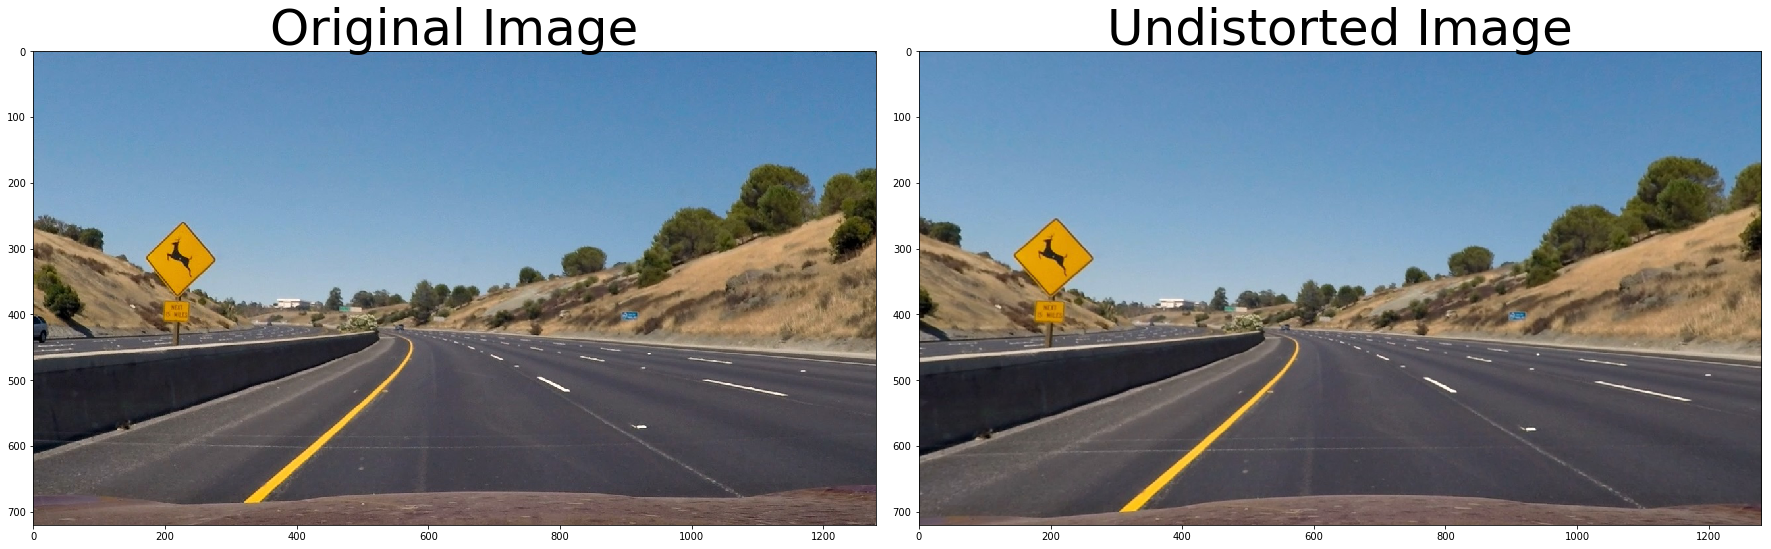

In [24]:
# Read an image
# img = mpimg.imread('video_images/frame1.jpg')
# for i in range(1,15):
#     img = mpimg.imread("video_images/frame" + str(i) + ".jpg")
#     result = laneDetection(img)
#     plt.figure()
#     plt.title('Frame' + str(i))
#     plt.imshow(result)

img = mpimg.imread("test_images/test2.jpg")
result = laneDetection(img)
# plt.figure()
# plt.imshow(result)

# Read an image
# laneImages = list(map(laneDetection, test_images))
# show_images(laneImages)

# Video

In [113]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [75]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    return laneDetection(image)

In [81]:
#os.remove('project_video_output.mp4')
#os.remove('project_video_output1.mp4')
#os.remove('project_video_output2.mp4')
white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
#clip1 = VideoFileClip("project_video.mp4")
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


 58%|█████▊    | 728/1261 [04:06<02:54,  3.06it/s]

problema dreapta


 61%|██████    | 764/1261 [04:18<02:48,  2.94it/s]

problema dreapta


100%|█████████▉| 1260/1261 [07:09<00:00,  3.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 30s, sys: 1min 32s, total: 5min 2s
Wall time: 7min 12s


In [82]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [257]:
cap = cv2.VideoCapture('project_video.mp4')
count = 0
limit = 50
while cap.isOpened():
    ret,frame = cap.read()
    if ret == False:
        break
    if (count > 0 and count < 15):
        cv2.imwrite("video_images/frame%d.jpg" % count, frame)
    count = count + 1

print(count)
cap.release()

1260


In [88]:
white_output = 'challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
#clip1 = VideoFileClip("project_video.mp4")
clip1 = VideoFileClip("challenge_video.mp4")
#clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4



 10%|▉         | 48/485 [00:12<02:16,  3.20it/s]

problema dreapta



 10%|█         | 49/485 [00:12<02:23,  3.05it/s]

problema dreapta



 10%|█         | 50/485 [00:13<02:20,  3.09it/s]

problema dreapta



 11%|█         | 51/485 [00:13<02:17,  3.15it/s]

problema dreapta



 11%|█         | 52/485 [00:13<02:23,  3.02it/s]

problema dreapta



 11%|█         | 53/485 [00:14<02:19,  3.09it/s]

problema dreapta



 11%|█         | 54/485 [00:14<02:17,  3.14it/s]

problema dreapta



 11%|█▏        | 55/485 [00:14<02:22,  3.02it/s]

problema dreapta



 12%|█▏        | 56/485 [00:15<02:18,  3.10it/s]

problema dreapta



 12%|█▏        | 57/485 [00:15<02:15,  3.15it/s]

problema dreapta



 12%|█▏        | 58/485 [00:15<02:20,  3.04it/s]

problema dreapta



 12%|█▏        | 59/485 [00:16<02:17,  3.10it/s]

problema dreapta



 12%|█▏        | 60/485 [00:16<02:15,  3.13it/s]

problema dreapta



 13%|█▎        | 61/485 [00:16<02:20,  3.02it/s]

problema dreapta



 13%|█▎        | 62/485 [00:17<02:17,  3.08it/s]

problema dreapta



 13%|█▎        | 63/485 [00:17<02:15,  3.12it/s]

problema dreapta



 13%|█▎        | 64/485 [00:17<02:20,  3.01it/s]

problema dreapta



 13%|█▎        | 65/485 [00:18<02:17,  3.06it/s]

problema dreapta



 14%|█▎        | 66/485 [00:18<02:14,  3.11it/s]

problema dreapta



 14%|█▍        | 67/485 [00:18<02:19,  2.99it/s]

problema dreapta



 14%|█▍        | 68/485 [00:19<02:16,  3.05it/s]

problema dreapta



 14%|█▍        | 69/485 [00:19<02:14,  3.10it/s]

problema dreapta



 14%|█▍        | 70/485 [00:19<02:18,  3.00it/s]

problema dreapta



 15%|█▍        | 71/485 [00:20<02:14,  3.08it/s]

problema dreapta



 15%|█▍        | 72/485 [00:20<02:11,  3.13it/s]

problema dreapta



 15%|█▌        | 73/485 [00:20<02:17,  3.01it/s]

problema dreapta



 15%|█▌        | 74/485 [00:21<02:12,  3.10it/s]

problema dreapta



 15%|█▌        | 75/485 [00:21<02:15,  3.02it/s]

problema dreapta



 16%|█▌        | 76/485 [00:21<02:12,  3.09it/s]

problema dreapta



 16%|█▌        | 77/485 [00:21<02:09,  3.15it/s]

problema dreapta



 16%|█▌        | 78/485 [00:22<02:15,  3.01it/s]

problema dreapta



 16%|█▋        | 79/485 [00:22<02:13,  3.05it/s]

problema dreapta



 16%|█▋        | 80/485 [00:22<02:10,  3.10it/s]

problema dreapta



 17%|█▋        | 81/485 [00:23<02:15,  2.97it/s]

problema dreapta



 17%|█▋        | 82/485 [00:23<02:12,  3.05it/s]

problema dreapta



 17%|█▋        | 83/485 [00:23<02:08,  3.12it/s]

problema dreapta



 17%|█▋        | 84/485 [00:24<02:13,  3.01it/s]

problema dreapta



 18%|█▊        | 85/485 [00:24<02:11,  3.05it/s]

problema dreapta



 18%|█▊        | 86/485 [00:24<02:09,  3.09it/s]

problema dreapta



 18%|█▊        | 87/485 [00:25<02:11,  3.02it/s]

problema dreapta



 18%|█▊        | 88/485 [00:25<02:07,  3.11it/s]

problema dreapta



 18%|█▊        | 89/485 [00:25<02:11,  3.02it/s]

problema stanga



 19%|█▉        | 94/485 [00:27<02:06,  3.09it/s]

problema dreapta



 20%|█▉        | 95/485 [00:27<02:02,  3.17it/s]

problema dreapta



 22%|██▏       | 107/485 [00:31<02:04,  3.04it/s]

problema stanga



 22%|██▏       | 108/485 [00:32<02:01,  3.11it/s]

problema stanga



 25%|██▌       | 123/485 [00:36<01:57,  3.08it/s]

problema stanga



 26%|██▌       | 124/485 [00:37<01:54,  3.15it/s]

problema stanga



 26%|██▌       | 125/485 [00:37<01:57,  3.08it/s]

problema stanga



 26%|██▌       | 126/485 [00:37<01:54,  3.15it/s]

problema stanga



 26%|██▌       | 127/485 [00:38<01:56,  3.08it/s]

problema stanga



 27%|██▋       | 130/485 [00:39<01:51,  3.18it/s]

problema stanga



 27%|██▋       | 131/485 [00:39<01:54,  3.09it/s]

problema stanga



 27%|██▋       | 132/485 [00:39<01:51,  3.17it/s]

problema stanga



 27%|██▋       | 133/485 [00:40<01:55,  3.05it/s]

problema stanga
problema dreapta



 28%|██▊       | 134/485 [00:40<01:52,  3.12it/s]

problema stanga
problema dreapta



 28%|██▊       | 135/485 [00:40<01:55,  3.04it/s]

problema stanga
problema dreapta



 28%|██▊       | 136/485 [00:41<01:51,  3.12it/s]

problema dreapta



 28%|██▊       | 137/485 [00:41<01:54,  3.04it/s]

problema dreapta



 29%|██▉       | 140/485 [00:42<01:52,  3.07it/s]

problema stanga



 29%|██▉       | 142/485 [00:43<01:53,  3.02it/s]

problema stanga



 32%|███▏      | 157/485 [00:48<02:02,  2.67it/s]

problema stanga



 33%|███▎      | 158/485 [00:48<02:03,  2.66it/s]

problema stanga



 33%|███▎      | 159/485 [00:49<02:03,  2.65it/s]

problema stanga



 33%|███▎      | 160/485 [00:49<02:02,  2.64it/s]

problema stanga



 33%|███▎      | 161/485 [00:49<02:01,  2.67it/s]

problema stanga



 33%|███▎      | 162/485 [00:50<02:01,  2.66it/s]

problema stanga



 34%|███▎      | 163/485 [00:50<02:02,  2.63it/s]

problema stanga



 69%|██████▊   | 333/485 [01:46<00:48,  3.16it/s]

problema dreapta



 70%|███████   | 340/485 [01:48<00:46,  3.09it/s]

problema dreapta



 70%|███████   | 341/485 [01:49<00:45,  3.16it/s]

problema dreapta



 71%|███████   | 342/485 [01:49<00:47,  3.04it/s]

problema dreapta



 71%|███████   | 343/485 [01:49<00:45,  3.12it/s]

problema dreapta



 77%|███████▋  | 372/485 [01:59<00:35,  3.16it/s]

problema stanga



 77%|███████▋  | 373/485 [01:59<00:36,  3.05it/s]

problema stanga



 77%|███████▋  | 374/485 [01:59<00:35,  3.13it/s]

problema stanga



 77%|███████▋  | 375/485 [02:00<00:36,  3.04it/s]

problema stanga



 78%|███████▊  | 376/485 [02:00<00:35,  3.11it/s]

problema stanga



 78%|███████▊  | 377/485 [02:00<00:35,  3.04it/s]

problema stanga



 78%|███████▊  | 378/485 [02:00<00:34,  3.14it/s]

problema stanga



 78%|███████▊  | 379/485 [02:01<00:34,  3.09it/s]

problema stanga



 78%|███████▊  | 380/485 [02:01<00:34,  3.04it/s]

problema stanga



 79%|███████▊  | 381/485 [02:01<00:33,  3.11it/s]

problema stanga



 79%|███████▉  | 382/485 [02:02<00:32,  3.15it/s]

problema stanga



 79%|███████▉  | 383/485 [02:02<00:33,  3.03it/s]

problema stanga



 79%|███████▉  | 384/485 [02:02<00:32,  3.09it/s]

problema stanga



 79%|███████▉  | 385/485 [02:03<00:31,  3.15it/s]

problema stanga



 80%|███████▉  | 386/485 [02:03<00:32,  3.02it/s]

problema stanga



 80%|███████▉  | 387/485 [02:03<00:31,  3.07it/s]

problema stanga



 80%|████████  | 388/485 [02:04<00:30,  3.13it/s]

problema stanga



 80%|████████  | 389/485 [02:04<00:31,  3.04it/s]

problema stanga



 80%|████████  | 390/485 [02:04<00:30,  3.11it/s]

problema stanga



 81%|████████  | 391/485 [02:05<00:30,  3.06it/s]

problema stanga



 81%|████████  | 392/485 [02:05<00:29,  3.12it/s]

problema stanga



 81%|████████  | 393/485 [02:05<00:30,  3.04it/s]

problema stanga



 81%|████████  | 394/485 [02:06<00:29,  3.08it/s]

problema stanga



 81%|████████▏ | 395/485 [02:06<00:28,  3.13it/s]

problema stanga



 82%|████████▏ | 396/485 [02:06<00:29,  3.01it/s]

problema stanga



 82%|████████▏ | 397/485 [02:07<00:28,  3.07it/s]

problema stanga



 82%|████████▏ | 398/485 [02:07<00:27,  3.14it/s]

problema stanga



 82%|████████▏ | 399/485 [02:07<00:26,  3.22it/s]

problema stanga



 82%|████████▏ | 400/485 [02:08<00:27,  3.08it/s]

problema stanga



 83%|████████▎ | 401/485 [02:08<00:26,  3.12it/s]

problema stanga



 83%|████████▎ | 402/485 [02:08<00:26,  3.17it/s]

problema stanga



 83%|████████▎ | 403/485 [02:09<00:26,  3.05it/s]

problema stanga



 83%|████████▎ | 404/485 [02:09<00:25,  3.13it/s]

problema stanga



 94%|█████████▍| 455/485 [02:25<00:09,  3.07it/s]

problema dreapta



100%|██████████| 485/485 [02:35<00:00,  3.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 1min 19s, sys: 30.4 s, total: 1min 49s
Wall time: 2min 38s


In [91]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))